#  Importing needed libraries

In [18]:
import numpy as np 
import pandas as pd 
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
import os

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#  Loading *labels*

In [3]:
labels = pd.read_csv(r'D:\Study_3\GTSRB_new\signnames.csv')

# Check point
print(labels.head())
print()

print(labels.iloc[0][1])  # Speed limit (20km/h)
print(labels['SignName'][1]) # Speed limit (30km/h)


   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Speed limit (20km/h)
Speed limit (30km/h)


#  Loading trained Keras CNN model for Classification

(1, 32, 32)


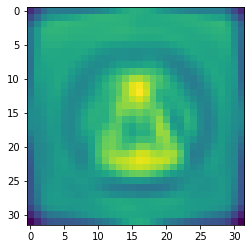

In [4]:
# Loading trained CNN model to use it later when classifying from 4 groups into one of 43 classes
model = load_model(r'D:\Study_3\GTSRB_new\training\new_model.h5')

# Loading mean image to use for preprocessing further (mean image substraction)
with open(r'D:\Study_3\mean_image_gray.pickle', 'rb') as f:
    mean = pickle.load(f) 
    
print(mean['mean_image_gray'].shape) 
plt.imshow(mean['mean_image_gray'].reshape(32, 32, 1))

# Loading YOLO v3 network by OpenCV dnn library

## Loading *trained weights* and *cfg file* into the Network

In [6]:
path_to_weights = r'D:\Study_3\weights\yolov3_ts_train_last.weights'
path_to_cfg = r'D:\Study_3\yolov3_ts_test.cfg'

# Loading trained YOLO v3 weights and cfg configuration file by 'dnn' library from OpenCV
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

# To use with GPU
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

## Getting output layers where detections are made 

In [7]:
# Getting names of all YOLO v3 layers
layers_all = network.getLayerNames()

# Check point
# print(layers_all)

# Getting only detection YOLO v3 layers that are 82, 94 and 106
layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]

# Check point
print()
print(layers_names_output)  



['yolo_82', 'yolo_94', 'yolo_106']


## Setting probability, threshold and colour for bounding boxes

In [8]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.2

# Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.2

# Generating colours for bounding boxes
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(type(colours))  
print(colours.shape)
print(colours[0])  


<class 'numpy.ndarray'>
(43, 3)
[119  25 168]


# Reading input images

In [12]:
# Reading image with OpenCV library
image_BGR = cv2.imread(r'D:\Study_3\00001.jpg')
# image_BGR = cv2.imread(r'C:\Users\ronak\Desktop\test_video\image-1.jpeg')

# Check point
# Showing image shape
print('Image shape:', image_BGR.shape) 

# Getting height and width dimensions of input image
h, w = image_BGR.shape[:2]  

# Check point
# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))  


Image shape: (800, 1360, 3)
Image height=800 and width=1360


# Processing single image

In [13]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    # img = img/255
    return img

Total amount of time 0.56904 seconds
(46, 62, 3)
(46, 62)
(1, 1, 32, 32)


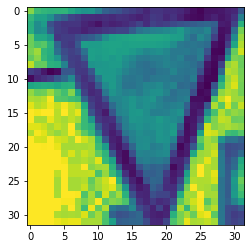

(1, 32, 32, 1)
13
Yield
(39, 39, 3)
(39, 39)
(1, 1, 32, 32)


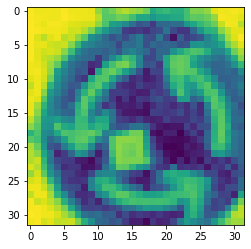

(1, 32, 32, 1)
40
Roundabout mandatory
(56, 50, 3)
(56, 50)
(1, 1, 32, 32)


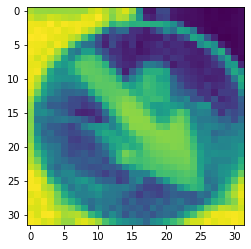

(1, 32, 32, 1)
38
Keep right


True

In [14]:
# Variable for counting total processing time
t = 0

# Blob from current frame
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Forward pass with blob through output layers
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Time
t += end - start
print('Total amount of time {:.5f} seconds'.format(t))

# Lists for detected bounding boxes, confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial frame size
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Getting top left corner coordinates
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                

# Implementing non-maximum suppression of given bounding boxes
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Checking if there is any detected object been left
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Bounding box coordinates, its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
        # Cut fragment with Traffic Sign
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
        print(c_ts.shape)
        c_ts = preprocessing(c_ts)
        print(c_ts.shape)

            
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            # Getting preprocessed blob with Traffic Sign of needed shape
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=False, crop=False)
            print(blob_ts.shape)
            #blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_gray']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            plt.imshow(blob_ts[0, :, :, :])
            plt.show()
            print(blob_ts.shape)

            # Feeding to the Keras CNN model to get predicted label among 43 classes
            scores = model.predict(blob_ts)

            # Scores is given for image with 43 numbers of predictions for each class
            # Getting only one class with maximum value
            prediction = np.argmax(scores)
            print(prediction)
            print(labels['SignName'][prediction])


            # Colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()
            
            # Green BGR
            colour_box_current = [0, 255, 61]
            
            # Drawing bounding box on the original current frame
            cv2.rectangle(image_BGR, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 4)

            # Preparing text with label and confidence for current bounding box
            text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                   confidences[i])
            
            # Putting text with label and confidence on the original image
            cv2.putText(image_BGR, text_box_current, (x_min, y_min - 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
            
  
         
# Saving image
cv2.imwrite(r'D:\Study_3\results\2\result.png', image_BGR)


# Showing processed image

Image shape: (800, 1360, 3)
Image height=800 and width=1360


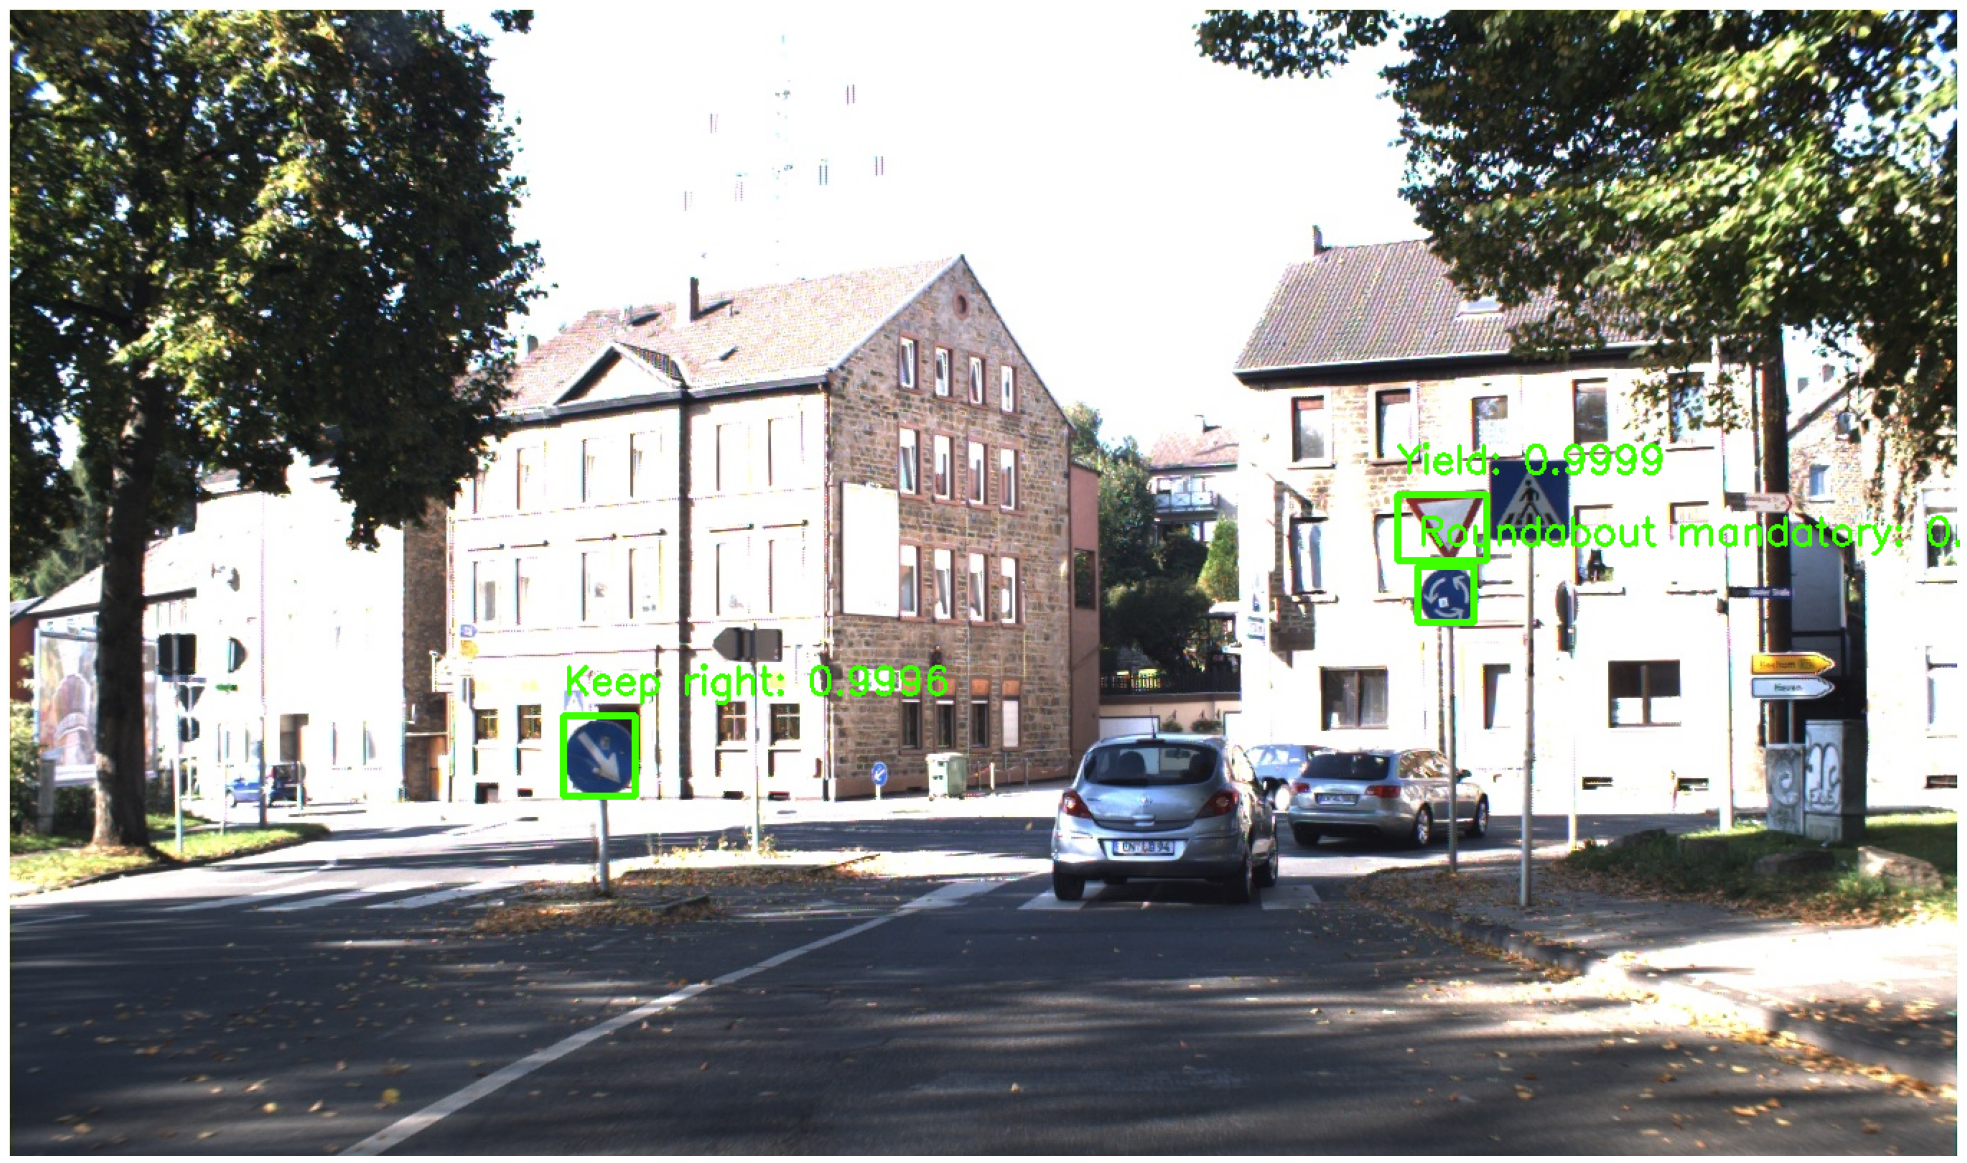

In [15]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (35.0, 35.0) 

image_BGR = cv2.imread(r'D:\Study_3\results\2\result.png')

# Showing image shape
print('Image shape:', image_BGR.shape) 

h, w = image_BGR.shape[:2] 

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))  # 800 1360

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Showing the plot
plt.show()

plt.close()


In [17]:
# Saving locally without committing
from IPython.display import FileLink

FileLink(r'D:\Study_3\results\2\result.png')


D:\Study_3\results\2\result.png